In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
from sklearn.model_selection import train_test_split
import pandas as pd
import imghdr
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay,classification_report
import numpy as np
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing import image
from keras.utils import Sequence
from imblearn.over_sampling import SMOTE,BorderlineSMOTE
from imblearn.tensorflow import balanced_batch_generator
import cv2
import tensorflow as tf
from tensorflow.keras.callbacks import Callback,ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from tensorflow.keras.applications import Xception,ResNet152V2,EfficientNetV2B0,InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Input,GlobalAveragePooling2D
from collections import Counter
import keras_tuner
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, Adamax
import itertools

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# EDA

In [23]:
data_path = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train'
classes = [
    'MildDemented/',
    'ModerateDemented/',
    'NonDemented/',
    'VeryMildDemented/']

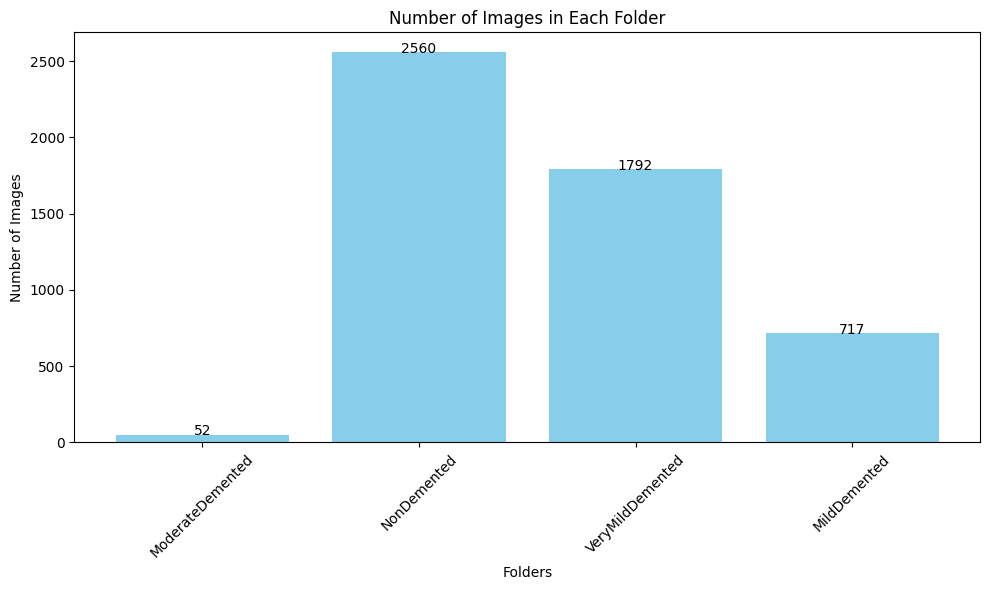

In [24]:
directories = os.listdir(data_path)

folders = []
file_counts = []


for directory in directories:
    folder = os.path.join(data_path, directory)
    if os.path.isdir(folder):
        folders.append(directory)
        files = os.listdir(folder)
        image_count = len([file for file in files if file.endswith(('jpg'))])
        file_counts.append(image_count)


plt.figure(figsize=(10, 6))
bars = plt.bar(folders, file_counts, color='skyblue')
plt.bar(folders, file_counts, color='skyblue')
plt.xlabel('Folders')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Folder')
plt.xticks(rotation=45)
for bar, count in zip(bars, file_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5, str(count), ha='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()

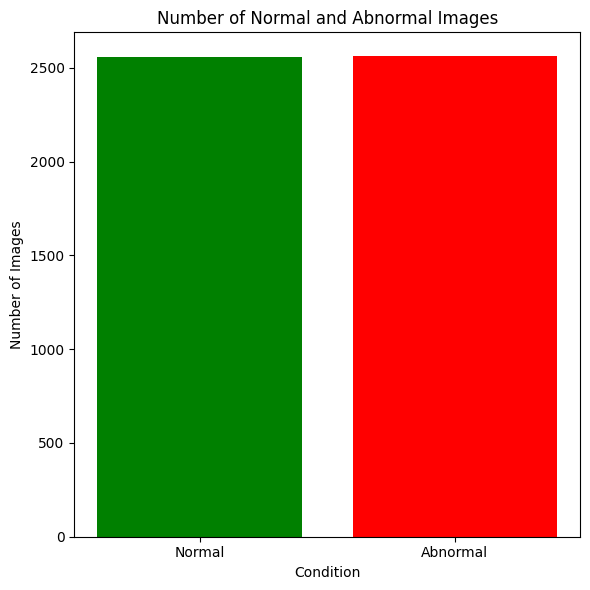

In [25]:
normal_count = 0
abnormal_count = 0
for directory in directories:
    folder = os.path.join(data_path, directory)
    if os.path.isdir(folder):
        files = os.listdir(folder)
        image_count = len([file for file in files if file.endswith('.jpg')])


        if directory.startswith('Non'):
            normal_count += image_count
        else:
            abnormal_count += image_count


plt.figure(figsize=(6, 6))
labels = ['Normal', 'Abnormal']
counts = [normal_count, abnormal_count]

plt.bar(labels, counts, color=['green', 'red'])
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.title('Number of Normal and Abnormal Images')
plt.tight_layout()
plt.show()

In [26]:
def get_random_sample_images(folder, label):
    files = os.listdir(folder)
    image_files = [file for file in files if file.endswith('.jpg')]
    random.shuffle(image_files)
    selected_images = image_files[:3]
    for image_name in selected_images:
        image_path = os.path.join(folder, image_name)
        img = Image.open(image_path)
        sample_images.append(img)
        sample_names.append(image_name)
        sample_classes.append(label)

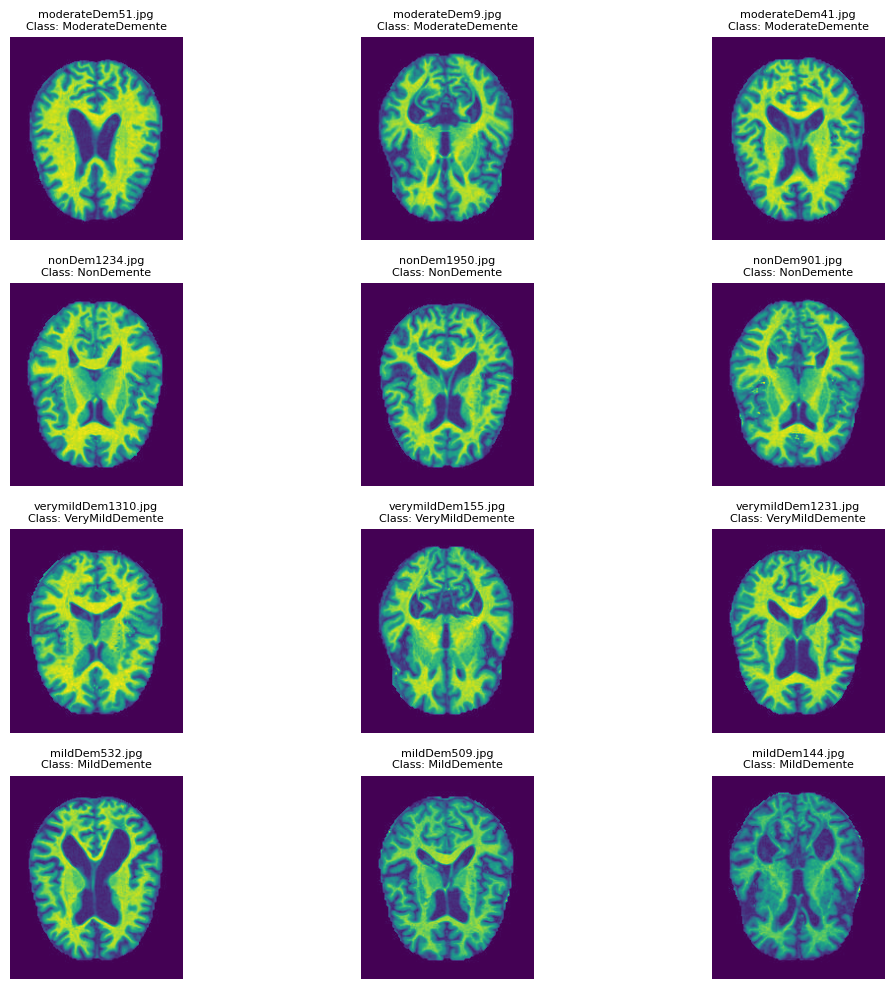

In [27]:
sample_images = []
sample_names = []
sample_classes = []
for directory in directories:
    folder = os.path.join(data_path, directory)
    if os.path.isdir(folder):
        get_random_sample_images(folder, directory[:-1])

num_images = len(sample_images)
num_cols = 3
num_rows = (num_images + num_cols - 1) // num_cols

plt.figure(figsize=(12, 10))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"{sample_names[i]}\nClass: {sample_classes[i]}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [28]:
file_paths = []
labels = []

for class_name in classes:
    folder = os.path.join(data_path, class_name)
    if os.path.isdir(folder):
        files = os.listdir(folder)
        file_paths.extend([os.path.join(folder, file) for file in files])
        labels.extend([class_name[:-1] for _ in range(len(files))])

data = pd.DataFrame({'file_path': file_paths, 'label': labels})

In [29]:
def get_image_dimensions(file_path):
    try:
        img = Image.open(file_path)
        width, height = img.size
        return width, height
    except Exception as e:
        print(f"Error: {e}")
        return None

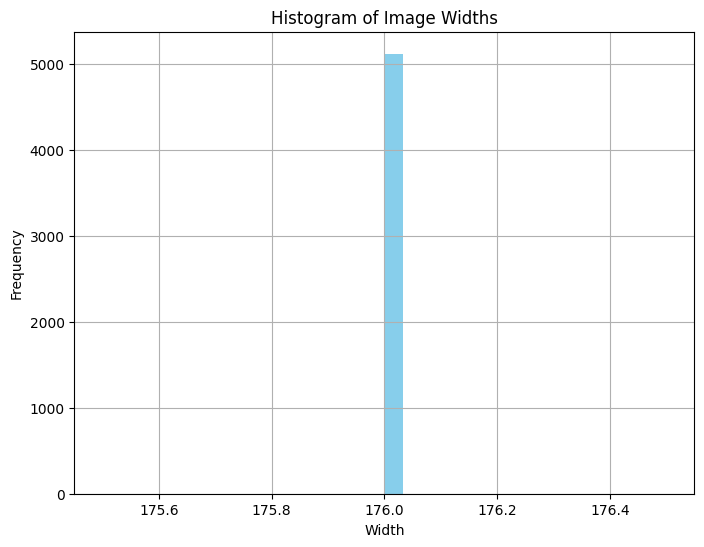

In [30]:
data['dimensions'] = data['file_path'].apply(get_image_dimensions)
data['width'] = data['dimensions'].apply(lambda x: x[0] if x else None)
data['height'] = data['dimensions'].apply(lambda x: x[1] if x else None)
plt.figure(figsize=(8, 6))
plt.hist(data['width'], bins=30, color='skyblue')
plt.title('Histogram of Image Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

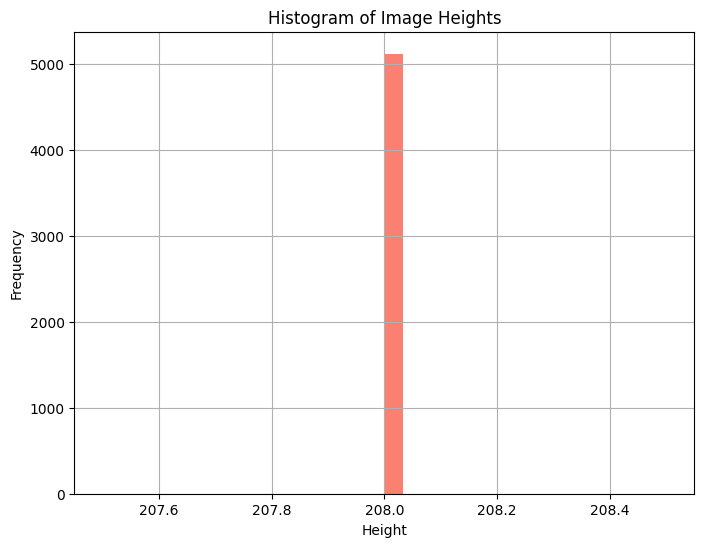

In [31]:
plt.figure(figsize=(8, 6))
plt.hist(data['height'], bins=30, color='salmon')
plt.title('Histogram of Image Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [32]:
def check_image_mode(image_path):
    img = Image.open(image_path)
    mode = img.mode
    if mode == 'RGB':
        return 'c'  #color
    elif mode == 'L':
        return 'g'  #grey
    else:
        return 'o'  

In [33]:
data['color_or_grey'] = data['file_path'].apply(check_image_mode)

In [35]:
data['color_or_grey'].value_counts()

color_or_grey
g    5121
Name: count, dtype: int64

- All Images are grey

# Data Preprocessing

In [2]:
data_path = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train'

classes = [
    'MildDemented/',
    'ModerateDemented/',
    'NonDemented/',
    'VeryMildDemented/']

file_paths = []
labels = []

for class_name in classes:
    folder = os.path.join(data_path, class_name)
    if os.path.isdir(folder):
        files = os.listdir(folder)
        file_paths.extend([os.path.join(folder, file) for file in files])
        labels.extend([class_name[:-1] for _ in range(len(files))])

train_df = pd.DataFrame({'file_path': file_paths, 'label': labels})

In [37]:
train_df 

,file_path,label
0,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
1,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
2,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
3,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
4,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
...,...,...
5116,/kaggle/input/alzheimers-dataset-4-class-of-im...,VeryMildDemented
5117,/kaggle/input/alzheimers-dataset-4-class-of-im...,VeryMildDemented
5118,/kaggle/input/alzheimers-dataset-4-class-of-im...,VeryMildDemented
5119,/kaggle/input/alzheimers-dataset-4-class-of-im...,VeryMildDemented


In [39]:
train_df['label'].value_counts()

label
NonDemented         2560
VeryMildDemented    1792
MildDemented         717
ModerateDemented      52
Name: count, dtype: int64

In [3]:
data_path = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test'

classes = [
    'MildDemented/',
    'ModerateDemented/',
    'NonDemented/',
    'VeryMildDemented/']

file_paths = []
labels = []

for class_name in classes:
    folder = os.path.join(data_path, class_name)
    if os.path.isdir(folder):
        files = os.listdir(folder)
        file_paths.extend([os.path.join(folder, file) for file in files])
        labels.extend([class_name[:-1] for _ in range(len(files))])

test_df = pd.DataFrame({'file_path': file_paths, 'label': labels})

In [41]:
test_df

,file_path,label
0,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
1,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
2,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
3,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
4,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
...,...,...
1274,/kaggle/input/alzheimers-dataset-4-class-of-im...,VeryMildDemented
1275,/kaggle/input/alzheimers-dataset-4-class-of-im...,VeryMildDemented
1276,/kaggle/input/alzheimers-dataset-4-class-of-im...,VeryMildDemented
1277,/kaggle/input/alzheimers-dataset-4-class-of-im...,VeryMildDemented


In [4]:
test_df, valid_df = train_test_split(test_df,  test_size= 0.6, shuffle= True, random_state= 123)

In [43]:
test_df

,file_path,label
1056,/kaggle/input/alzheimers-dataset-4-class-of-im...,VeryMildDemented
725,/kaggle/input/alzheimers-dataset-4-class-of-im...,NonDemented
142,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
827,/kaggle/input/alzheimers-dataset-4-class-of-im...,NonDemented
489,/kaggle/input/alzheimers-dataset-4-class-of-im...,NonDemented
...,...,...
1238,/kaggle/input/alzheimers-dataset-4-class-of-im...,VeryMildDemented
1147,/kaggle/input/alzheimers-dataset-4-class-of-im...,VeryMildDemented
106,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
1041,/kaggle/input/alzheimers-dataset-4-class-of-im...,VeryMildDemented


In [44]:
test_df['label'].value_counts()

label
NonDemented         252
VeryMildDemented    188
MildDemented         68
ModerateDemented      3
Name: count, dtype: int64

In [45]:
valid_df

,file_path,label
226,/kaggle/input/alzheimers-dataset-4-class-of-im...,NonDemented
1052,/kaggle/input/alzheimers-dataset-4-class-of-im...,VeryMildDemented
13,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
433,/kaggle/input/alzheimers-dataset-4-class-of-im...,NonDemented
362,/kaggle/input/alzheimers-dataset-4-class-of-im...,NonDemented
...,...,...
973,/kaggle/input/alzheimers-dataset-4-class-of-im...,VeryMildDemented
890,/kaggle/input/alzheimers-dataset-4-class-of-im...,VeryMildDemented
1099,/kaggle/input/alzheimers-dataset-4-class-of-im...,VeryMildDemented
1103,/kaggle/input/alzheimers-dataset-4-class-of-im...,VeryMildDemented


In [46]:
valid_df['label'].value_counts()

label
NonDemented         388
VeryMildDemented    260
MildDemented        111
ModerateDemented      9
Name: count, dtype: int64

In [5]:
batch_size=16
img_size = (224, 224)
train_datagen= ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)
test_datagen= ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)
# Keep mode rgb even the data are in grayscale to corresponse the pretrained model input channel
train_gen = train_datagen.flow_from_dataframe(train_df, x_col= 'file_path', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = test_datagen.flow_from_dataframe(valid_df, x_col= 'file_path', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = test_datagen.flow_from_dataframe(test_df, x_col= 'file_path', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5121 validated image filenames belonging to 4 classes.
Found 768 validated image filenames belonging to 4 classes.
Found 511 validated image filenames belonging to 4 classes.


In [6]:
# Adjust weight for imbalanced data
# Since I tried SMOTE and data augmentation and they didn't work :(
class_labels = train_df['label'].unique()
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=train_df['label']
)
class_weights_dict = dict(zip(class_labels, class_weights))


class_indices = {label: idx for idx, label in enumerate(class_labels)}


class_weights_dict = {class_indices[label]: weight for label, weight in class_weights_dict.items()}

print("Class Weights Dictionary:")
print(class_weights_dict)

Class Weights Dictionary:
{0: 1.7855648535564854, 1: 24.620192307692307, 2: 0.50009765625, 3: 0.7144252232142857}


# Model Eval Function

In [7]:
def model_eval(model,test_gen):
    class_names = list(test_gen.class_indices.keys())
    class_mapping = {}
    for i, label in enumerate(class_names):
        class_mapping[label] = i
    predictions = model.predict(test_gen)
    y_pred_classes= np.argmax(predictions,axis=1)
    y_true =test_gen.classes
    class_report = classification_report(y_true, y_pred_classes,target_names=class_names)
    print("Classification Report:")
    print(class_report)
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    cmd = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    cmd.plot(ax=ax)
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Model Building

In [8]:
METRICS = [
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),
    "accuracy"
    ]

In [9]:
def create_callbacks(modelname,monitorvalue,mode):
    checkpoint = ModelCheckpoint(filepath=modelname,
                             monitor=monitorvalue,
                             save_best_only=True)

    stop = EarlyStopping(monitor=monitorvalue, 
                     mode=mode,
                     patience=15,
                     verbose=1, 
                     restore_best_weights=True)
    callbacks = [checkpoint,stop]
    
    return callbacks 

In [10]:
def convert_model(input_path,output_name):
    model = keras.models.load_model(input_path)
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(output_name, 'wb') as f_out:
        f_out.write(tflite_model)

- Baseline CNN model

In [10]:
model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', 
                 kernel_regularizer=regularizers.l2(0.001), 
                 input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))


model.add(Flatten())


model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))


model.add(Dense(4, activation='softmax')) 


model.compile(optimizer=Adam(), loss='categorical_crossentropy', 
              metrics=METRICS )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [14]:
callbacks=create_callbacks("baseline.h5","accuracy","max")

In [15]:
steps_per_epoch = len(train_gen)
validation_steps = len(valid_gen)
history = model.fit(train_gen, epochs=20, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=valid_gen, 
                    validation_steps=validation_steps,
                    class_weight=class_weights_dict,
                   callbacks=callbacks)

Epoch 1/20
321/321 [==============================] - ETA: 0s - loss: 1.3304 - precision: 0.5996 - recall: 0.3755 - auc: 0.8217 - prc: 0.5822 - accuracy: 0.5179

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


321/321 [==============================] - 11s 35ms/step - loss: 1.3304 - precision: 0.5996 - recall: 0.3755 - auc: 0.8217 - prc: 0.5822 - accuracy: 0.5179 - val_loss: 1.3696 - val_precision: 0.4915 - val_recall: 0.3385 - val_auc: 0.7601 - val_prc: 0.4550 - val_accuracy: 0.4622
Epoch 2/20
321/321 [==============================] - 11s 33ms/step - loss: 0.6257 - precision: 0.6713 - recall: 0.4630 - auc: 0.8623 - prc: 0.6623 - accuracy: 0.5930 - val_loss: 1.5146 - val_precision: 0.5131 - val_recall: 0.4349 - val_auc: 0.7780 - val_prc: 0.4918 - val_accuracy: 0.4922
Epoch 3/20
321/321 [==============================] - 11s 34ms/step - loss: 0.6528 - precision: 0.6816 - recall: 0.4566 - auc: 0.8599 - prc: 0.6620 - accuracy: 0.5948 - val_loss: 1.7502 - val_precision: 0.5059 - val_recall: 0.4440 - val_auc: 0.7715 - val_prc: 0.4773 - val_accuracy: 0.4987
Epoch 4/20
321/321 [==============================] - 11s 34ms/step - loss: 0.5800 - precision: 0.6857 - recall: 0.5079 - auc: 0.8775 - prc: 

32/32 [==============================] - 1s 24ms/step
Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.14      0.01      0.03        68
ModerateDemented       0.25      0.33      0.29         3
     NonDemented       0.53      0.85      0.65       252
VeryMildDemented       0.46      0.24      0.32       188

        accuracy                           0.51       511
       macro avg       0.35      0.36      0.32       511
    weighted avg       0.45      0.51      0.44       511



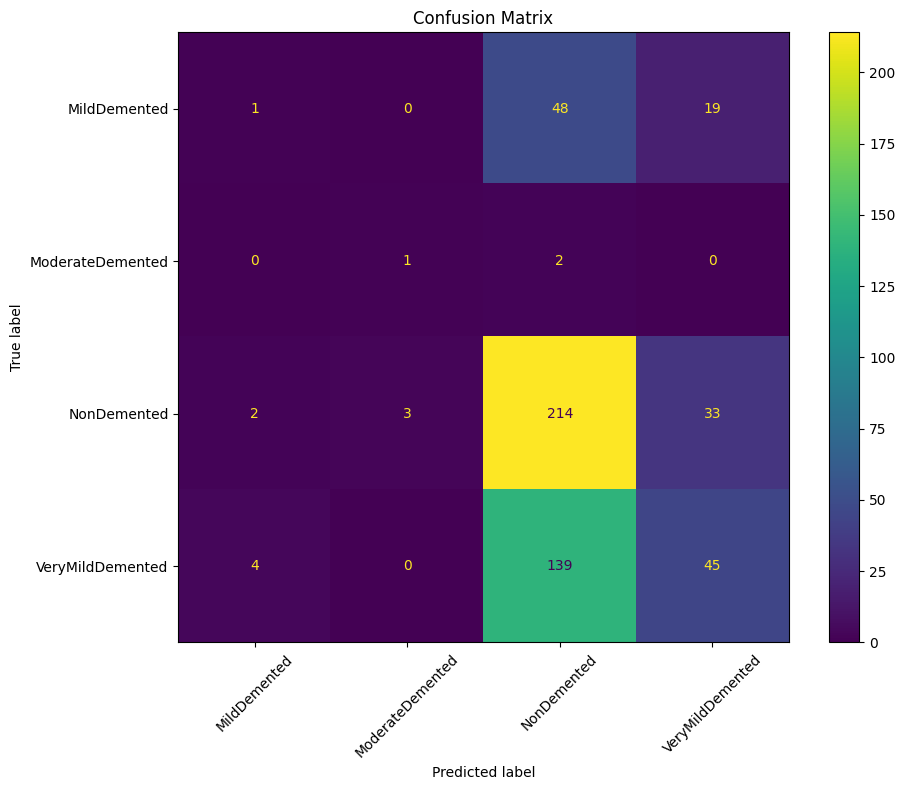

In [16]:
model.evaluate(test_gen)
model_eval(model,test_gen)

- CNN with hyperparameter tuning

In [17]:
def cnn_model(hp):
    model = Sequential()

    hp_filters = hp.Int('filters', min_value=32, max_value=128, step=32)
    hp_dropout = hp.Float('dropout', min_value=0.3, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.add(Conv2D(hp_filters, (3, 3), 
                     activation='relu',
                     kernel_regularizer=regularizers.l2(0.001),
                     input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(hp_filters * 2, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(hp_filters * 4, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())


    model.add(Flatten())


    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp_dropout))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp_dropout))

    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=Adamax(learning_rate=hp_learning_rate),
                  loss=tf.keras.losses.CategoricalFocalCrossentropy(),
                  metrics=METRICS)

    return model

In [18]:
tuner = keras_tuner.BayesianOptimization(
    cnn_model,
    objective=keras_tuner.Objective('val_loss', direction='min'), 
    max_trials=10,
    alpha=0.0001,
    beta=2.6,
    seed=42,
    directory='hyperparam_tuning',         
    project_name='cnn_tuning'   
)

In [19]:
tuner.search(train_gen, 
             steps_per_epoch=len(train_gen), 
             validation_data=valid_gen, 
             validation_steps=len(valid_gen), 
             class_weight=class_weights_dict,
             epochs=10) 

Trial 10 Complete [00h 01m 52s]
val_loss: 0.10371788591146469

Best val_loss So Far: 0.10371788591146469
Total elapsed time: 00h 24m 23s


In [20]:
model = tuner.get_best_models(num_models=1)[0]

32/32 [==============================] - 1s 24ms/step
Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.42      0.31      0.36        68
ModerateDemented       0.00      0.00      0.00         3
     NonDemented       0.83      0.38      0.53       252
VeryMildDemented       0.44      0.81      0.58       188

        accuracy                           0.53       511
       macro avg       0.42      0.38      0.36       511
    weighted avg       0.63      0.53      0.52       511



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


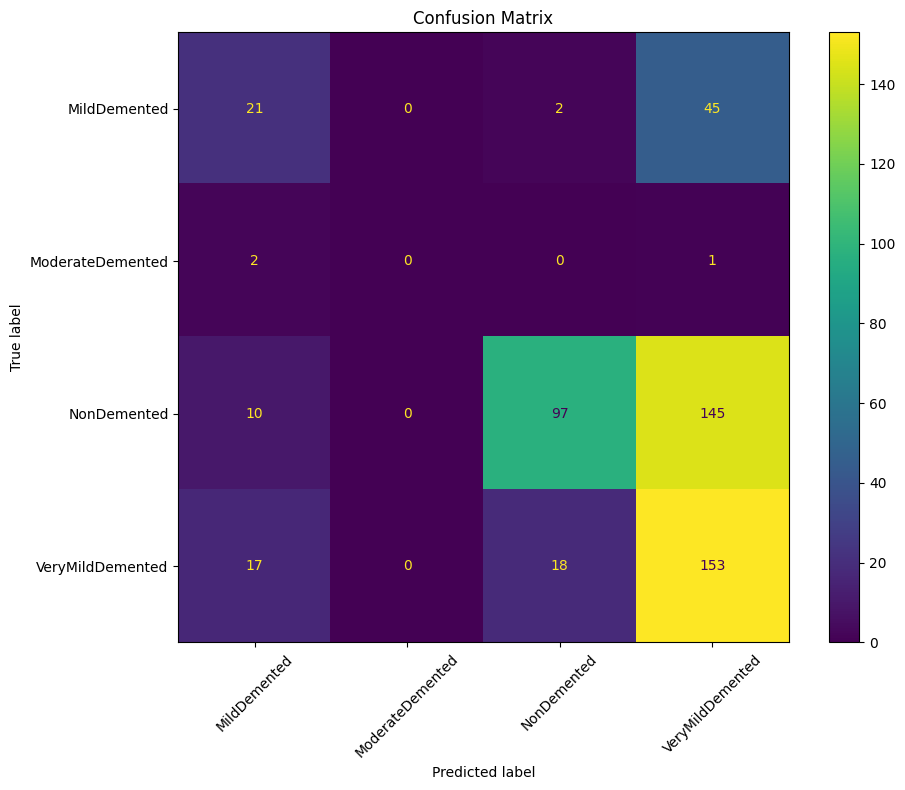

In [21]:
model.evaluate(test_gen)
model_eval(model,test_gen)

# Pretrained model

In [11]:
def build_pretrained(base_model,loss):
    model = Sequential([
        base_model,
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dense(256, kernel_regularizer=regularizers.l2(l=0.01),
              activity_regularizer= regularizers.l1(0.006),
              bias_regularizer= regularizers.l1(0.006),
              activation='relu'),
        Dropout(rate= 0.4, seed= 42),
        Dense(4, activation='softmax')
        ])
    model.compile(loss=loss,
              optimizer=Adamax(learning_rate= 0.001),
              metrics=METRICS
                 )
    model.summary()
    return model

- EfficientNetv2

In [9]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='max')

52606240/52606240 [==============================] - 3s 0us/step


In [18]:
model=build_pretrained(base_model,tf.keras.losses.CategoricalCrossentropy())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 1536)              12930622  
 nal)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 1536)              6144      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               393472    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 13331266 (50.85 MB)
Trainable params: 13

In [19]:
callbacks=create_callbacks("efficient.h5","accuracy","max")

In [20]:
history = model.fit(train_gen, epochs=50, 
                    validation_data=valid_gen, 
                    #class_weight=class_weights_dict,
                    callbacks=callbacks,
                    validation_steps= None, 
                    shuffle= False)

Epoch 1/50


2024-01-07 08:58:23.812983: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetv2-b3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


321/321 [==============================] - ETA: 0s - loss: 5.3015 - precision: 0.6005 - recall: 0.4259 - auc: 0.7996 - prc: 0.5777 - accuracy: 0.5433

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


321/321 [==============================] - 110s 146ms/step - loss: 5.3015 - precision: 0.6005 - recall: 0.4259 - auc: 0.7996 - prc: 0.5777 - accuracy: 0.5433 - val_loss: 4.2055 - val_precision: 0.6396 - val_recall: 0.4922 - val_auc: 0.8491 - val_prc: 0.6613 - val_accuracy: 0.5742
Epoch 2/50
321/321 [==============================] - 40s 123ms/step - loss: 3.5864 - precision: 0.7589 - recall: 0.5249 - auc: 0.8950 - prc: 0.7502 - accuracy: 0.6665 - val_loss: 3.1164 - val_precision: 0.7475 - val_recall: 0.4935 - val_auc: 0.8870 - val_prc: 0.7381 - val_accuracy: 0.6615
Epoch 3/50
321/321 [==============================] - 40s 123ms/step - loss: 2.5489 - precision: 0.8473 - recall: 0.7196 - auc: 0.9519 - prc: 0.8800 - accuracy: 0.7934 - val_loss: 2.4888 - val_precision: 0.6907 - val_recall: 0.6602 - val_auc: 0.9005 - val_prc: 0.7612 - val_accuracy: 0.6810
Epoch 4/50
321/321 [==============================] - 39s 122ms/step - loss: 1.7669 - precision: 0.9161 - recall: 0.8616 - auc: 0.9807 - 

32/32 [==============================] - 3s 28ms/step
Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.85      0.43      0.57        68
ModerateDemented       0.33      1.00      0.50         3
     NonDemented       0.81      0.87      0.84       252
VeryMildDemented       0.72      0.76      0.74       188

        accuracy                           0.77       511
       macro avg       0.68      0.76      0.66       511
    weighted avg       0.78      0.77      0.76       511



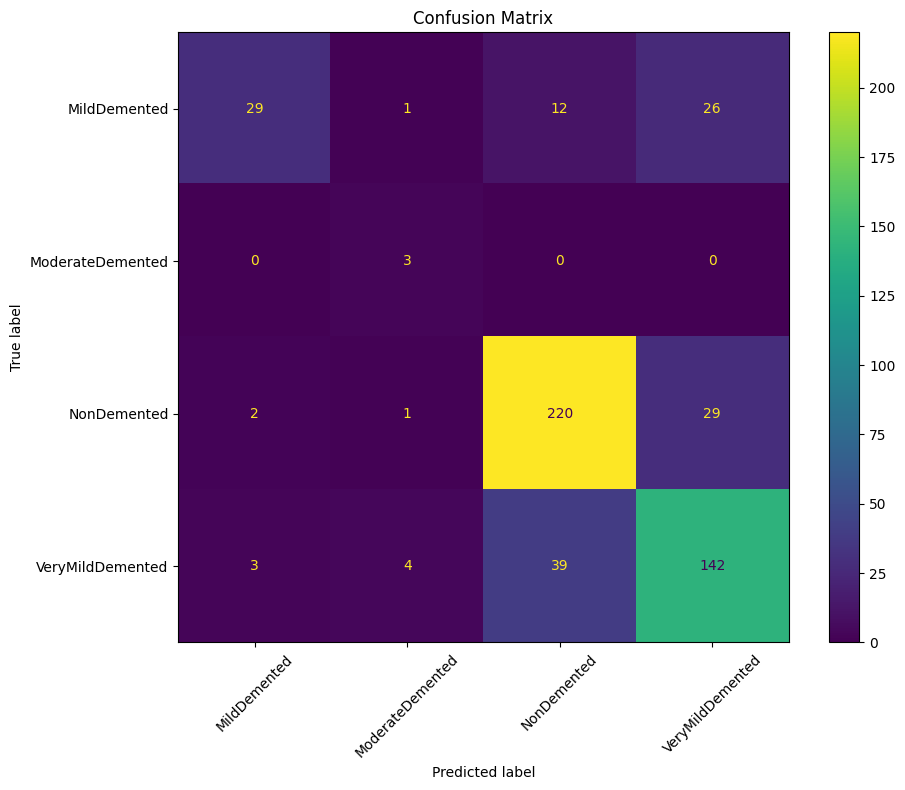

In [21]:
model.evaluate(test_gen)
model_eval(model,test_gen)

In [35]:
loaded_model = tf.keras.models.load_model('/kaggle/working/efficient.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
image_path = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
classes = [
    'MildDemented',
    'ModerateDemented',
    'NonDemented',
    'VeryMildDemented']
score = tf.nn.softmax(predictions[0])
print(f"{classes[tf.argmax(score)]}")

1/1 [==============================] - 0s 28ms/step
MildDemented


In [24]:
convert_model("/kaggle/working/efficient.h5","efficientnetv2b3.tflite")

- InceptionV3

In [12]:
base_model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='max')

87910968/87910968 [==============================] - 0s 0us/step


In [13]:
model=build_pretrained(base_model,tf.keras.losses.CategoricalFocalCrossentropy())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 22336548 (85.21 MB)
Trainable params: 22298020 (85.06 MB)
Non-trainable params: 38528 (150.50 KB)
__________

In [14]:
callbacks=create_callbacks("inceptionv3.h5","accuracy","max")

In [15]:
history = model.fit(train_gen, epochs=50, 
                    validation_data=valid_gen, 
                    class_weight=class_weights_dict,
                    callbacks=callbacks,
                    validation_steps= None, 
                    shuffle= False)

Epoch 1/50
321/321 [==============================] - ETA: 0s - loss: 3.8632 - precision: 0.4861 - recall: 0.1502 - auc: 0.7178 - prc: 0.4255 - accuracy: 0.4649

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


321/321 [==============================] - 72s 117ms/step - loss: 3.8632 - precision: 0.4861 - recall: 0.1502 - auc: 0.7178 - prc: 0.4255 - accuracy: 0.4649 - val_loss: 3.1162 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8120 - val_prc: 0.5674 - val_accuracy: 0.5169
Epoch 2/50
321/321 [==============================] - 31s 96ms/step - loss: 2.6468 - precision: 0.8436 - recall: 0.0906 - auc: 0.8448 - prc: 0.6299 - accuracy: 0.5856 - val_loss: 2.2965 - val_precision: 1.0000 - val_recall: 0.0208 - val_auc: 0.8502 - val_prc: 0.6452 - val_accuracy: 0.5820
Epoch 3/50
321/321 [==============================] - 31s 96ms/step - loss: 1.9090 - precision: 0.9156 - recall: 0.1736 - auc: 0.9120 - prc: 0.7682 - accuracy: 0.7135 - val_loss: 1.6674 - val_precision: 0.7407 - val_recall: 0.0781 - val_auc: 0.8120 - val_prc: 0.5725 - val_accuracy: 0.5521
Epoch 4/50
321/321 [==============================] - 31s 96ms/step - loss: 1.3246 - precision: 0.9504 - recall: 0.3070 - auc: 0.955

32/32 [==============================] - 2s 28ms/step
Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.76      0.69      0.72        68
ModerateDemented       1.00      0.67      0.80         3
     NonDemented       0.73      0.94      0.82       252
VeryMildDemented       0.87      0.58      0.70       188

        accuracy                           0.77       511
       macro avg       0.84      0.72      0.76       511
    weighted avg       0.79      0.77      0.76       511



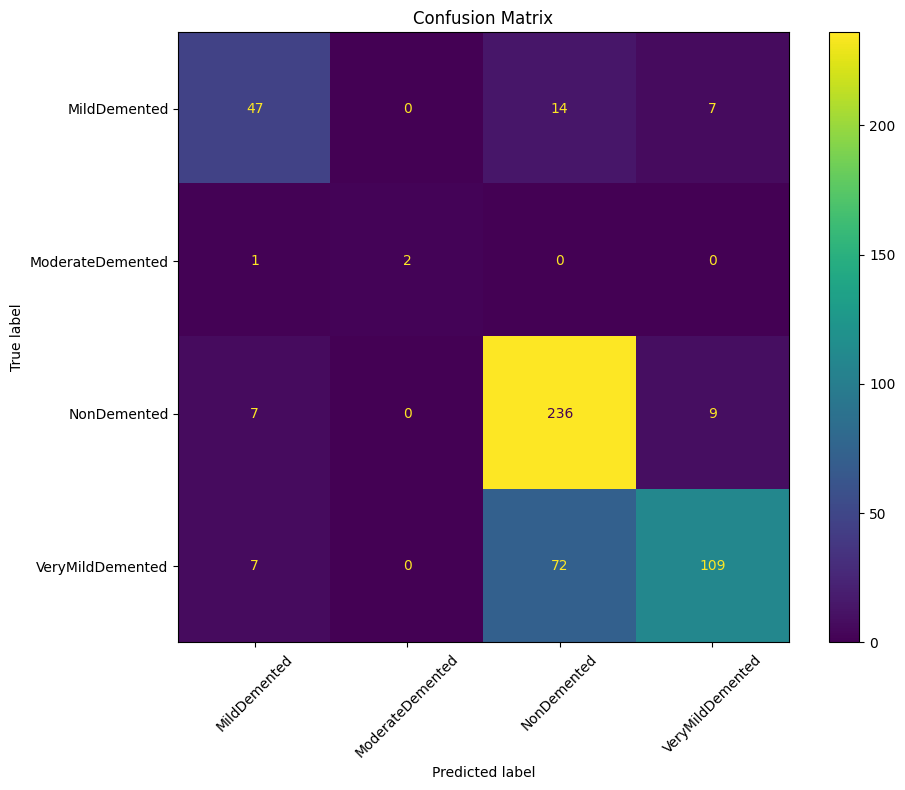

In [16]:
model.evaluate(test_gen)
model_eval(model,test_gen)

- I finally choose InceptionV3 after long experiment

In [17]:
convert_model("/kaggle/working/inceptionv3.h5","inceptionv3.tflite")

# Test TFlite model

In [18]:
!pip install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime
!pip install keras-image-helper

Looking in indexes: https://pypi.org/simple, https://google-coral.github.io/py-repo/
  Obtaining dependency information for tflite_runtime from https://files.pythonhosted.org/packages/9e/1f/aade0d066bacbe697946ae21f0467a702d81adb939bb64515e9abebae9ed/tflite_runtime-2.14.0-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 35.2 MB/s eta 0:00:00a 0:00:01


In [19]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
import tflite_runtime.interpreter as tflite
from keras_image_helper import create_preprocessor

In [20]:
interpreter = tflite.Interpreter(model_path="/kaggle/working/inceptionv3.tflite")
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [21]:
preprocessor = create_preprocessor("inception_v3", target_size=(224, 224))

In [31]:
image_path = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg'
X = preprocessor.from_path(image_path)

In [32]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)

In [33]:
classes = [
    'MildDemented',
    'ModerateDemented',
    'NonDemented',
    'VeryMildDemented']

In [34]:
class_pred_dict = dict(zip(classes, preds[0]))
max_class = max(class_pred_dict, key=class_pred_dict.get)
max_class

'ModerateDemented'